# Train

In [2]:
import tensorflow as tf
import datetime
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import pickle
import numpy as np
import cv2
import os
import pandas as pd

In [3]:
def load_data(BASE_PATH, is_train= True):
# loop over the rows
    data = []
    targets = []
    filenames = []
    ppclass = []

    if is_train:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "train_labels.csv"])
        IMAGES_PATH = os.path.sep.join([BASE_PATH, "train"])
    else:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "test_labels.csv"])
        IMAGES_PATH = os.path.sep.join([BASE_PATH, "test"])
    # load the contents of the CSV annotations file
    print("[INFO] loading dataset...")
    df = pd.read_csv(ANNOTS_PATH)
    for i in range(len(df)):
    # break the row into the filename and bounding box coordinates
        filename = df.loc[i]['filename']
        startX = df.loc[i]['xmin']
        startY = df.loc[i]['ymin']
        endX = df.loc[i]['xmax']
        endY = df.loc[i]['ymax']
        pclass = df.loc[i]['class']
        w = df.loc[i]['width']
        h = df.loc[i]['height']
    
        # derive the path to the input image, load the image (in OpenCV
        # format), and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]
        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h
    
        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        
        # update our list of data, targets, and filenames
        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
        ppclass.append(pclass)
        
        #print(targets)
        
        # convert the data and targets to NumPy arrays, scaling the input
        # pixel intensities from the range [0, 255] to [0, 1]
    data = np.array(data, dtype="float32") / 255.0
    targets = np.array(targets, dtype="float32")
    ppclass= np.array(ppclass)
        
    return data, targets, filenames, ppclass

In [4]:
# define the path to the base output directory
BASE_OUTPUT = "/your_project/output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector_multiclass.h5"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plot"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images_multiclass.txt"])

# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/your_project/data"

In [5]:
train_data, train_targets, train_filenames, train_ppclass=load_data(BASE_PATH, is_train= True)
test_data, test_targets, test_filenames, test_ppclass=load_data(BASE_PATH, is_train= False)

[INFO] loading dataset...
[INFO] loading dataset...


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_ppclass)
test_labels = lb.transform(test_ppclass)

In [7]:
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
    train_labels = to_categorical(train_labels)
    

In [8]:
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(test_filenames))
f.close()

[INFO] saving testing filenames...


In [9]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [10]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)

In [11]:
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [12]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"],loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

/Users/qiuyanxu/codes/pokemonDetection/ying_sun_interview/pokemon/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 block4_pool (MaxPooling2D)     (None, 14, 14, 512)  0           ['block4_conv3[0][0]']           
                                                                                                  
 block5_conv1 (Conv2D)          (None, 14, 14, 512)  2359808     ['block4_pool[0][0]']            
                                                                                                  
 block5_conv2 (Conv2D)          (None, 14, 14, 512)  2359808     ['block5_conv1[0][0]']           
                                                                                                  
 block5_conv3 (Conv2D)          (None, 14, 14, 512)  2359808     ['block5_conv2[0][0]']           
                                                                                                  
 block5_pool (MaxPooling2D)     (None, 7, 7, 512)    0           ['block5_conv3[0][0]']           
          

In [13]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": train_labels,
    "bounding_box": train_targets
}

In [14]:
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": test_labels,
    "bounding_box": test_targets
}

In [15]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
H = model.fit(
    train_data, trainTargets,
    validation_data=(test_data, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    callbacks=[tensorboard_callback])

[INFO] training bounding box regressor...
Epoch 1/10
24/24 [==============================] - 281s 12s/step - loss: 0.1677 - bounding_box_loss: 0.0481 - class_label_loss: 0.1196 - bounding_box_accuracy: 0.5913 - class_label_accuracy: 0.3495 - val_loss: 0.1381 - val_bounding_box_loss: 0.0369 - val_class_label_loss: 0.1012 - val_bounding_box_accuracy: 0.6481 - val_class_label_accuracy: 0.4249
Epoch 2/10
24/24 [==============================] - 242s 10s/step - loss: 0.1247 - bounding_box_loss: 0.0309 - class_label_loss: 0.0938 - bounding_box_accuracy: 0.6544 - class_label_accuracy: 0.5085 - val_loss: 0.1353 - val_bounding_box_loss: 0.0355 - val_class_label_loss: 0.0999 - val_bounding_box_accuracy: 0.6567 - val_class_label_accuracy: 0.4528
Epoch 3/10
24/24 [==============================] - 239s 10s/step - loss: 0.1094 - bounding_box_loss: 0.0296 - class_label_loss: 0.0798 - bounding_box_accuracy: 0.6583 - class_label_accuracy: 0.5887 - val_loss: 0.1234 - val_bounding_box_loss: 0.0339 - va

In [17]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving object detector model...


In [18]:
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label binarizer...


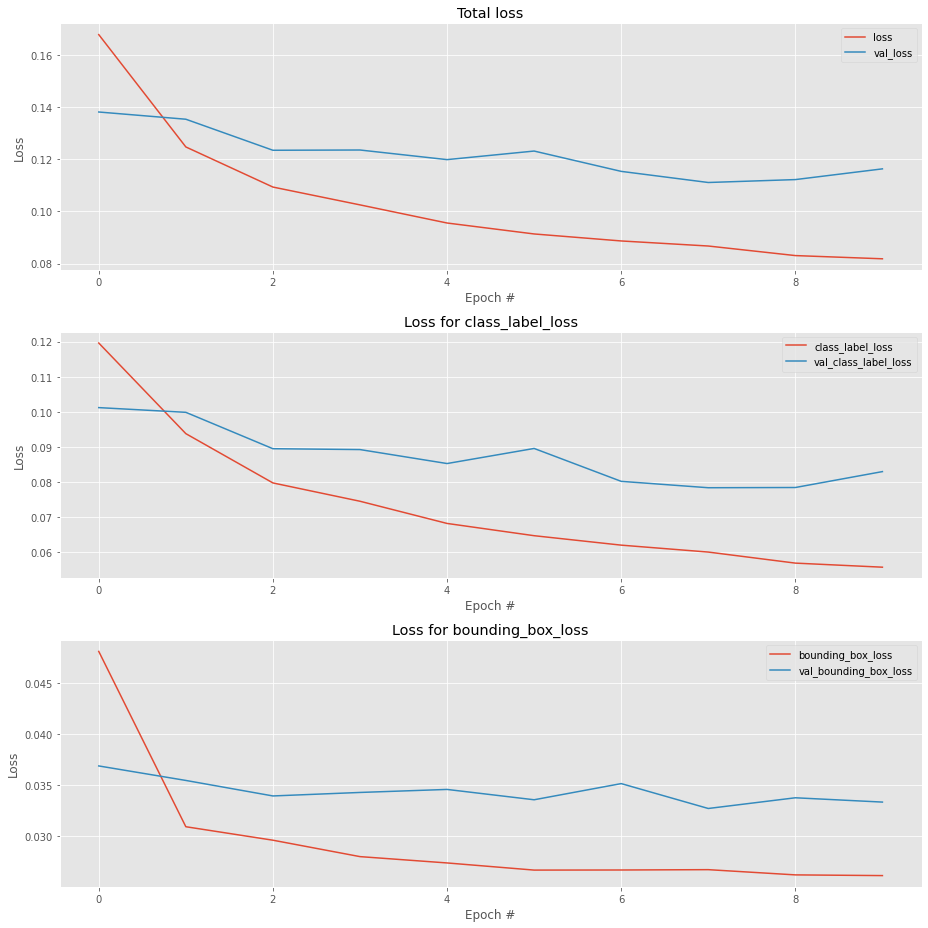

In [22]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
#plt.close()

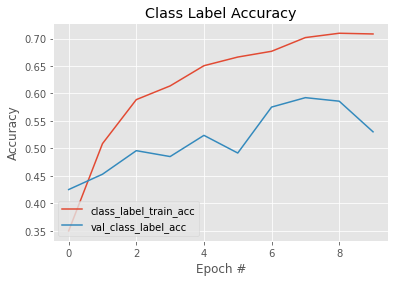

In [21]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
    label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)

# Predict

In [2]:
# construct the argument parser and parse the arguments
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os


In [12]:
BASE_OUTPUT = "/Users/qiuyanxu/gravitate/projects/pokemon/output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector_multiclass.h5"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plot"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True, help="path to input image/text file of image paths")
args = vars(ap.parse_args("--input /Users/qiuyanxu/codes/pokemonDetection/ying_sun_interview/pikachu-08-169.jpeg".split()))

In [13]:
# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

In [14]:
imagePaths

['/Users/qiuyanxu/codes/pokemonDetection/ying_sun_interview/pikachu-08-169.jpeg']

In [15]:
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
    # load the filenames in our testing file and initialize our list
    # of image paths
    imagePaths = open(args["input"]).read().strip().split("\n")


In [6]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())  

[INFO] loading object detector...


2022-02-15 17:19:25.742389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
    # load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)

	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]

	# determine the class label with the largest predicted
	# probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]

# load the input image (in OpenCV format), resize it such that it
	# fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)

	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)

	# show the output image
	cv2.imshow("Output", image)
	cv2.waitKey(0)      
